# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


In [3]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [182]:
# Use this space for any additional import statements you need
from nltk.tokenize import WhitespaceTokenizer
from datetime import datetime

In [135]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(Counter(tokens).keys())
    lexical_diversity = (num_unique_tokens / num_tokens)
    
    num_characters = 0
    for token in tokens:
        num_characters += len(token)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

    
def is_emoji(s):
    return(s in all_language_emojis)

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    final_tokens = [word for word in tokens if not word in sw]
    return(final_tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    tk = WhitespaceTokenizer()
    final_text = tk.tokenize(text)
    return(final_text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [136]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/Volumes/GoogleDrive/My Drive/Masters of Applied Data Sciences/2022 - 3 - Fall/ADS509 - Text Mining/Module 1/Assignments/ADS509_Mod1/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter"
lyrics_folder = "lyrics"

artist_files = {'brunomars':'BrunoMars_follower_data.txt',
                'rihanna':'rihanna_follower_data.txt'}


In [137]:
cols = ['screen_name', 'name', 'id', 'location', 'followers_counts', 'friends_count', 'description']

twitter_data = pd.read_csv(os.path.join(data_location, twitter_folder, artist_files['brunomars']),
                           sep="\t",
                           quoting=3,
                           names=cols)

twitter_data['artist'] = "brunomars"

In [138]:
twitter_data_2 = pd.read_csv(os.path.join(data_location, twitter_folder, artist_files['rihanna']),
                             sep="\t",
                             quoting=3,
                             names=cols)

twitter_data_2['artist'] = "rihanna"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [139]:
twitter_data.head()

,screen_name,name,id,location,followers_counts,friends_count,description,artist
0,Juhlouca006,Julinhaaa Euuu,1.568742e+18,None,0.0,13.0,NaN,brunomars
1,Kais17846409,Kai’s,1.568742e+18,None,0.0,12.0,NaN,brunomars
2,bebelzi51760782,bebelzinha,1.568742e+18,None,0.0,6.0,NaN,brunomars
3,Anna75087389,Anna,1.568742e+18,None,0.0,19.0,NaN,brunomars
4,EmonAhm63829363,Dusto,1.568739e+18,None,0.0,15.0,Uzi,brunomars


In [140]:
# Read in the lyrics data  

folder = data_location + lyrics_folder
artists = ['brunomars', 'rihanna']

lyrics_data = pd.DataFrame(columns=['Artist', 'Title', 'Lyrics'])

for artist in artists:
    folder_path = os.path.join(folder, artist)
    lyric_files = os.listdir(folder_path)
    
    for file in lyric_files:
        with open(os.path.join(folder_path, file)) as file:
            lyrics = file.read()
            
        title = lyrics.split('\n')[0]
        text = lyrics.split('\n')[2:]
        
        dictform = {'Artist':[artist], 'Title':[title], 'Lyrics':[text]}
        
        lyrics_data = lyrics_data.append(pd.DataFrame(dictform))
        
        

lyrics_data['Lyrics'] = lyrics_data.apply(lambda row : (' '.join(row['Lyrics'])), axis = 1)
lyrics_data.head()

,Artist,Title,Lyrics
0,brunomars,Perm,"Now look at you, been walking in here looking ..."
0,brunomars,Moonshine,Hello You know you look even better than the w...
0,brunomars,Girl I Wait,Feel your heart beating fast Hold me close mak...
0,brunomars,Rest Of My Life,Everyday I wake up next to an angel More beaut...
0,brunomars,The Lazy Song,Today I don't feel like doing anything I just ...


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove punctuation
* Split on whitespace
* Remove stopwords (optional)

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove punctuation other than emojis or hashtags
* Split on whitespace
* Remove stopwords

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [141]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["Lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [142]:
lyrics_data.head()

,Artist,Title,Lyrics,tokens,num_tokens
0,brunomars,Perm,"Now look at you, been walking in here looking ...","[look, walking, looking, pretty, angry, mean, ...",266
0,brunomars,Moonshine,Hello You know you look even better than the w...,"[hello, know, look, even, better, way, night, ...",176
0,brunomars,Girl I Wait,Feel your heart beating fast Hold me close mak...,"[feel, heart, beating, fast, hold, close, make...",136
0,brunomars,Rest Of My Life,Everyday I wake up next to an angel More beaut...,"[everyday, wake, next, angel, beautiful, words...",84
0,brunomars,The Lazy Song,Today I don't feel like doing anything I just ...,"[today, dont, feel, like, anything, wanna, lay...",216


In [143]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [144]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
46122,brunomars,Chris Jr Williams aka ChrisJr4Eva87 C x ♓,"[chris, jr, williams, aka, chrisjr4eva87, c, x..."
14969,rihanna,⚖️,[⚖️]
71280,rihanna,Best way to boost your kid's IQ and make them ...,"[best, way, boost, kids, iq, make, smarter, pe..."
96864,brunomars,Put that smile 😁 on u 'nd life gonna be alright ✨,"[put, smile, 😁, u, nd, life, gonna, alright, ✨]"
101757,brunomars,❤,[❤]
21410,rihanna,👽,[👽]
79910,brunomars,🧡♊,[🧡♊]
341,rihanna,18❣️,[18❣️]
72912,brunomars,FAN ACCOUNT 💖🏳️‍🌈 🇲🇽 https://t.co/6vRSuxd9gr,"[fan, account, 💖🏳️‍🌈, 🇲🇽, httpstco6vrsuxd9gr]"
59967,brunomars,最近米津さん沼に落ちそうな🍺好きな大人 大好きな音楽やお酒、映画、美容、家族の事など備忘録的...,"[最近米津さん沼に落ちそうな🍺好きな大人, 大好きな音楽やお酒、映画、美容、家族の事など備忘..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: I would want to experiment with noun-phrase tokenization to see if that helps in creating more meaning within tokens.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [146]:
# your code here

rihanna_all_lyrics_tokens = []
brunomars_all_lyrics_tokens = []

rihanna_lyrics_df = lyrics_data.loc[lyrics_data['Artist']=='rihanna'].copy().reset_index(drop=True)

brunomars_lyrics_df = lyrics_data.loc[lyrics_data['Artist']=='brunomars'].copy().reset_index(drop=True)


for i in range(len(rihanna_lyrics_df)):
    rihanna_all_lyrics_tokens.extend(rihanna_lyrics_df['tokens'][i])
    
for i in range(len(brunomars_lyrics_df)):
    brunomars_all_lyrics_tokens.extend(brunomars_lyrics_df['tokens'][i])
    
artists = ['Rihanna', 'Bruno Mars']
tokens = [rihanna_all_lyrics_tokens, brunomars_all_lyrics_tokens]

for artist, tokens in zip(artists, tokens):
    print("{} Descriptive Statistics: \n".format(artist))
    descriptive_stats(tokens, verbose=True)
    print("\n")

Rihanna Descriptive Statistics: 

There are 36721 tokens in the data.
There are 2989 unique tokens in the data.
There are 168303 characters in the data.
The lexical diversity is 0.081 in the data.


Bruno Mars Descriptive Statistics: 

There are 14041 tokens in the data.
There are 1719 unique tokens in the data.
There are 64547 characters in the data.
The lexical diversity is 0.122 in the data.




Q: what observations do you make about these data? 

A: The number of unique tokens seems to go down in ratio to the number of tokens in the data. This makes sense, as the more tokens present, the more likely they will repeat. 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [256]:
# your code here

#### Methodology:

### 4 corpora = Rihanna Twitter, Rihanna Lyrics, Bruno Mars Twitter, Bruno Mars Lyrics.
### For each corporoa
#### For each word in corpora
##### count frequency of word, length of corpora, frequency in other 3 corpora, total length of other 3 corpora
##### Calculate ratio of concentration in corpora vs. concentration in other 3 corpora
##### Rank by top 10 ratio and then output final results


## Already created all lyrics tokens for artists. Now creating all description tokens for both artists. 
rihanna_all_twitter_tokens = []
brunomars_all_twitter_tokens = []

rihanna_twitter_df = twitter_data.loc[twitter_data['artist']=='rihanna'].copy().reset_index(drop=True)

brunomars_twitter_df = twitter_data.loc[twitter_data['artist']=='brunomars'].copy().reset_index(drop=True)


for i in range(len(rihanna_twitter_df)):
    rihanna_all_twitter_tokens.extend(rihanna_twitter_df['tokens'][i])
    
for i in range(len(brunomars_twitter_df)):
    brunomars_all_twitter_tokens.extend(brunomars_twitter_df['tokens'][i])

In [264]:
### Define the scope of docs and names

docs = [rihanna_all_twitter_tokens, rihanna_all_lyrics_tokens,
           brunomars_all_twitter_tokens, brunomars_all_lyrics_tokens]

doc_names = ['rihanna_all_twitter_tokens', 'rihanna_all_lyrics_tokens',
                 'brunomars_all_twitter_tokens', 'brunomars_all_lyrics_tokens']

In [265]:
### Define final results df and the information that will be collected

cols = ['doc_name', 
        'word', 
        'final_relative_concentration',
        'word_doc_freq', 
        'doc_length', 
        'doc_concentration',
        'freq_in_other_docs', 
        'length_other_docs', 
        'concentration_other_docs']


final_results_df = pd.DataFrame(columns=cols)

In [266]:
### Run the loop. For each doc, gather the statistics within that doc, 
### the statistics for the other 3 docs combined, and the final relative concentration
### Filter down to top 10 and output

start = datetime.now()
print("Process started: {}".format(start))

for doc, doc_name in zip(docs, doc_names):
    
    word_statistics = []
    
    ## Other-Document definition:  
    other_docs = [x for x in docs if x != doc]    
    other_docs_combined = []
    
    for other_doc in other_docs:
        other_docs_combined.extend(other_doc)
    
                
    
    for word in set(doc):
        
        ## In-Document statistics
        word_doc_freq = doc.count(word)
        doc_length = len(doc)
        doc_concentration = word_doc_freq / doc_length
        
        ## Other-Document statistics
        freq_in_other_docs = other_docs_combined.count(word)
        length_other_docs = len(other_docs_combined)
        concentration_other_docs = freq_in_other_docs / length_other_docs
        
        ## Final concentration (item to rank all words on)
        if freq_in_other_docs == 0:
            final_relative_concentration = 0.000001
        else:
            final_relative_concentration = doc_concentration / concentration_other_docs
        
        ## Append to statistics collection list
        word_statistics.append([doc_name, 
                               word,
                               round(final_relative_concentration, 4),
                               word_doc_freq, 
                               doc_length, 
                               round(doc_concentration,4),
                               freq_in_other_docs,
                               length_other_docs,
                               round(concentration_other_docs,4)])
        
        
    final_results_df = pd.concat([final_results_df, pd.DataFrame(columns=cols, data=word_statistics)])
        

        
end = datetime.now()

print("Process completed in: {}".format(end-start))
        
        

Process started: 2022-09-25 13:49:51.284716
Process completed in: 0:19:28.642739


In [273]:
### Define n: number of times word must appear in other docs
n = 20

top_10 = final_results_df.drop_duplicates() \
                         .loc[final_results_df['freq_in_other_docs']>= n, :] \
                         .sort_values('final_relative_concentration', ascending=False)[:10]
                        

top_10

,doc_name,word,final_relative_concentration,word_doc_freq,doc_length,doc_concentration,freq_in_other_docs,length_other_docs,concentration_other_docs
1309,brunomars_all_lyrics_tokens,lucky,95.7559,62,14041,0.0044,26,563826,0.0000
2040,rihanna_all_lyrics_tokens,jump,70.8495,125,36721,0.0034,26,541146,0.0000
1131,rihanna_all_lyrics_tokens,diamond,63.8590,91,36721,0.0025,21,541146,0.0000
1127,brunomars_all_lyrics_tokens,ooh,56.7585,147,14041,0.0105,104,563826,0.0002
2256,rihanna_all_lyrics_tokens,ay,50.1047,68,36721,0.0019,20,541146,0.0000
1006,brunomars_all_lyrics_tokens,lay,49.2820,27,14041,0.0019,22,563826,0.0000
1224,brunomars_all_lyrics_tokens,ta,48.1868,36,14041,0.0026,30,563826,0.0001
826,rihanna_all_lyrics_tokens,bright,39.9996,114,36721,0.0031,42,541146,0.0001
1830,rihanna_all_lyrics_tokens,kiss,39.6253,121,36721,0.0033,45,541146,0.0001
242,rihanna_all_lyrics_tokens,diamonds,39.2978,64,36721,0.0017,24,541146,0.0000


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The top tokens all came from the lyrics documents and seem to include some "slang" words. This makes sense, as one specific song may frequently use a slang word (repetitively in a chorus for example), whilst being scattered throughout the other documents. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [268]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

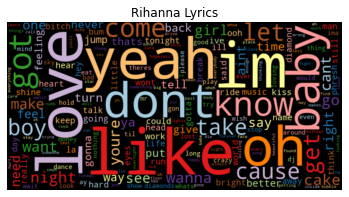

In [334]:
rihhanna_lyrics_word_freq = count_words(rihanna_lyrics_df, column='tokens')
wordcloud(rihhanna_lyrics_word_freq['freq'], title="Rihanna Lyrics")

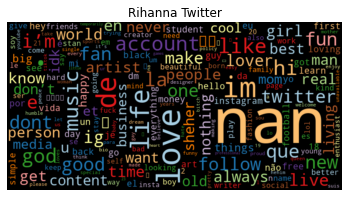

In [338]:
rihhanna_twitter_word_freq = count_words(rihanna_twitter_df, column='tokens')
wordcloud(rihhanna_twitter_word_freq['freq'], title="Rihanna Twitter")

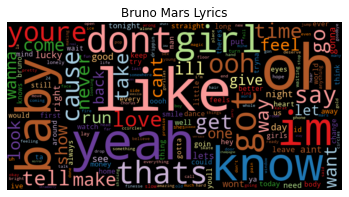

In [337]:
brunomars_lyrics_word_freq = count_words(brunomars_lyrics_df, column='tokens')
wordcloud(brunomars_lyrics_word_freq['freq'], title="Bruno Mars Lyrics")

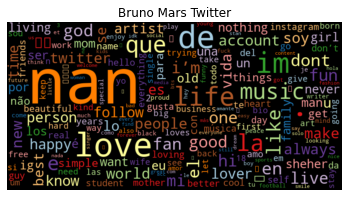

In [339]:
brunomars_twitter_word_freq = count_words(brunomars_twitter_df, column='tokens')
wordcloud(brunomars_twitter_word_freq['freq'], title="Bruno Mars Twitter")

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: There are very common words across the two artists / four documents. This makes sense, as both would fall into the Pop category. 